# Setup


In [ ]:
!pip install -U timm
!pip install -U fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00


# Imports

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from pathlib import Path
import numpy as np

from IPython.display import HTML
from ipywidgets import interact

from fastai.data.all import *
from fastai.vision.all import *
from fastai.tabular.all import *

import re
import timm
import os

# Read data

In [1]:
# This file usually
datafile = "https://keio.box.com/shared/static/lf28j0spz35brdsp8tg7w2tujpwl9txh.zip"
p = untar_data(datafile)

NameError: name 'untar_data' is not defined

In [ ]:
(p / "imgs") .ls()

(#1) [Path('/root/.fastai/data/lf28j0spz35brdsp8tg7w2tujpwl9txh/imgs/full')]

In [ ]:
# df = pd.read_parquet("slim.parquet")
df = pd.read_parquet(p  / "slim.parquet")
df = df.reset_index(names=["id"])

In [ ]:
df["apt_total_rent"] = (
    df["apt_rent_num"] +
    df["apt_admin_price_num"] / 10000 +
    df["apt_thanks_fee_num"] / 24 / 10000 +
    df["apt_deposit_num"] / 24/ 10000
)
df["log_total_rent"] = np.log(df["apt_total_rent"])
target = "log_total_rent"

““# Vision model

Lets take a look at all of the available convnext models.
I choose convnext because they seem to be quite time efficient according to [this](https://www.kaggle.com/code/jhoward/which-image-models-are-best/) notebook.


`convnextv2` is probably better than `convnext` and has many sizes. Lets pick the `tiny` one, because it looks good from the earlier notebook.

In [ ]:
timm.list_models('convnext*')
print(timm.list_models('beit*'))

['beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224']


In [ ]:
df

,id,b_name,apt_detail_link,b_address,b_age_int,b_closest_station_1,b_distance_station_1,b_method_station_1,b_closest_station_2,b_distance_station_2,...,apt_style,apt_floor_num,apt_admin_price_num,apt_thanks_fee_num,apt_total_rent_num,apt_deposit_num,images_url,images_path,apt_total_rent,log_total_rent
0,0,芝ビルディング,/chintai/jnc_000087159310/?bc=100358200602,東京都港区芝４,43,都営三田線/三田駅,5.0,歩,ＪＲ山手線/田町駅,9.0,...,ワンルーム,2,10000.0,66000.0,10006.599609,66000.0,https://img01.suumo.com/front/gazo/fr/bukken/602/100358200602/100358200602_co.jpg,full/b37725b78487a00f39f4bfbece78206e0aa583c2.jpg,8.150000,2.098018
1,1,芝ビルディング,/chintai/jnc_000086602953/?bc=100349405577,東京都港区芝４,43,都営三田線/三田駅,5.0,歩,ＪＲ山手線/田町駅,9.0,...,ワンルーム,8,10000.0,0.0,10008.500000,0.0,https://img01.suumo.com/front/gazo/fr/bukken/577/100349405577/100349405577_co.jpg,full/e4f4ee5ad22b89ec27574016ba56c40e34a760e7.jpg,9.500000,2.251292
2,2,アローニア野村,/chintai/jnc_000072878467/?bc=100355141791,東京都品川区荏原５,31,東急目黒線/西小山駅,6.0,歩,東急目黒線/洗足駅,12.0,...,ワンルーム,1,2000.0,48000.0,2004.800049,0.0,https://img01.suumo.com/front/gazo/fr/bukken/791/100355141791/100355141791_co.jpg,full/307a273ddcb5b8cc610048ae7e74fa1780be0188.jpg,5.200000,1.648659
3,3,アローニア野村,/chintai/jnc_000087109319/?bc=100357901171,東京都品川区荏原５,31,東急目黒線/西小山駅,6.0,歩,東急目黒線/洗足駅,12.0,...,ワンルーム,1,2000.0,48000.0,2004.800049,0.0,https://img01.suumo.com/front/gazo/fr/bukken/171/100357901171/100357901171_co.jpg,full/263733a794585d2944afe129436e488155f3aec8.jpg,5.200000,1.648659
4,4,アローニア野村,/chintai/jnc_000084484697/?bc=100344321955,東京都品川区荏原５,31,東急目黒線/西小山駅,6.0,歩,東急目黒線/洗足駅,12.0,...,ワンルーム,1,2000.0,48000.0,2004.800049,0.0,https://img01.suumo.com/front/gazo/fr/bukken/955/100344321955/100344321955_co.jpg,full/eb5d7cbaa1b9c976b5afe46f67d7453e2d664f47.jpg,5.200000,1.648659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12864,12864,MANOA白金高輪,/chintai/jnc_000077453684/?bc=100344440139,東京都港区高輪１,2,東京メトロ南北線/白金高輪駅,1.0,歩,都営浅草線/泉岳寺駅,12.0,...,1K,3,10000.0,137000.0,10013.700195,137000.0,https://img01.suumo.com/front/gazo/fr/bukken/139/100344440139/100344440139_co.jpg,full/a366302c20eaa1d96ffafd2b004523e7dd756105.jpg,15.841666,2.762644
12865,12865,ＺＵＫＡ ＤＡＩＫＡＮＹＡＭＡ,/chintai/jnc_000074054540/?bc=100340786138,東京都渋谷区恵比寿西１,2,東京メトロ日比谷線/恵比寿駅,4.0,歩,東急東横線/代官山駅,4.0,...,ワンルーム,2,5000.0,150000.0,5015.000000,75000.0,https://img01.suumo.com/front/gazo/fr/bukken/138/100340786138/100340786138_co.jpg,full/777266f434b06af308e43a192e52add6f2257962.jpg,16.437500,2.799565
12866,12866,都営大江戸線 麻布十番駅 6階建 築4年,/chintai/jnc_000058146114/?bc=100353938903,東京都港区東麻布３,4,都営大江戸線/麻布十番駅,1.0,歩,都営大江戸線/赤羽橋駅,5.0,...,1K,5,10000.0,158000.0,10015.799805,158000.0,https://img01.suumo.com/front/gazo/fr/bukken/903/100353938903/100353938903_co.jpg,full/2e6ffa88d2fd74f15c87e6b02a58df0b4b8e3c9a.jpg,18.116665,2.896832
12867,12867,東京メトロ南北線 白金高輪駅 地下1地上45階建 築1年,/chintai/jnc_000085802215/?bc=100357098446,東京都港区白金１,1,東京メトロ南北線/白金高輪駅,3.0,歩,東京メトロ南北線/麻布十番駅,12.0,...,ワンルーム,4,12000.0,191000.0,12019.099609,191000.0,https://img01.suumo.com/front/gazo/fr/bukken/446/100357098446/100357098446_co.jpg,full/52007c3285a8e85796aa3b4bc30323b12ed2130c.jpg,21.891668,3.086106


In [ ]:
imgdir = p

In [ ]:
import os
basepath = Path("/content/drive/MyDrive/models/realestate_models/meguro/")
os.makedirs(basepath, exist_ok=True)

In [ ]:
size = [224, 384, 512]
size = 224

model_name=f"beit_base_patch16_{size}"

viz_df=df[["id", "images_path", target]].copy()
viz_cbs=[
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname=str(basepath / model_name), with_opt=False)
]
BS=8
YRANGE=(0, 6)
METRICS=[R2Score()]
viz_dls = ImageDataLoaders.from_df(viz_df,
                                  path=imgdir /  "imgs",
                                  fn_col="images_path",
                                  label_col=target,
                                  n_workers=-1,
                                  item_tfms=[RandomResizedCrop((size, size))],
                                  y_block=RegressionBlock(), bs=BS)

viz_learner=vision_learner(viz_dls,
                        model_name,
                        metrics=METRICS,
                        y_range=YRANGE,
                        loss_func=MSELossFlat(),
                        n_out=1)

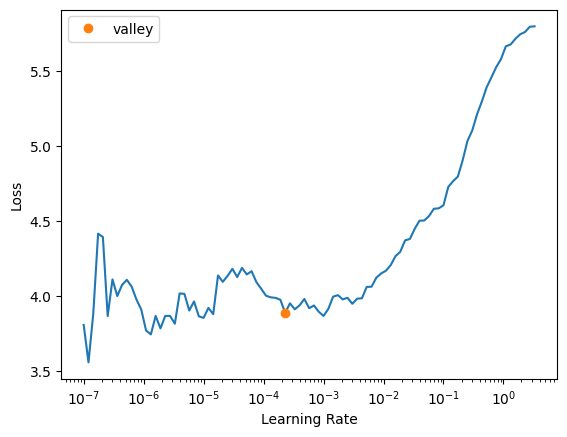

In [ ]:
lr = viz_learner.lr_find()

In [ ]:
df[df["b_closest_station_1"].str.contains("不動前")]

,id,b_name,apt_detail_link,b_address,b_age_int,b_closest_station_1,b_distance_station_1,b_method_station_1,b_closest_station_2,b_distance_station_2,...,apt_style,apt_floor_num,apt_admin_price_num,apt_thanks_fee_num,apt_total_rent_num,apt_deposit_num,images_url,images_path,apt_total_rent,log_total_rent
45,45,東急目黒線 不動前駅 9階建 築21年,/chintai/jnc_000033556823/?bc=100354642692,東京都品川区西五反田３,21,東急目黒線/不動前駅,3.0,歩,ＪＲ山手線/五反田駅,10.0,...,1K,3,5000.0,80000.0,5008.000000,0.0,https://img01.suumo.com/front/gazo/fr/bukken/692/100354642692/100354642692_co.jpg,full/80a71e22bd55b4241cf88ec12984db750fab88fe.jpg,8.833333,2.178532
46,46,東急目黒線 不動前駅 9階建 築21年,/chintai/jnc_000029769550/?bc=100354505161,東京都品川区西五反田３,21,東急目黒線/不動前駅,3.0,歩,ＪＲ山手線/五反田駅,10.0,...,1K,3,5000.0,80000.0,5008.000000,0.0,https://img01.suumo.com/front/gazo/fr/bukken/161/100354505161/100354505161_co.jpg,full/8cfa3e6edfc68f1e64ad0ec9c81f8afd35ab0c8c.jpg,8.833333,2.178532
47,47,東急目黒線 不動前駅 9階建 築21年,/chintai/jnc_000038817575/?bc=100354712631,東京都品川区西五反田３,21,東急目黒線/不動前駅,3.0,歩,ＪＲ山手線/五反田駅,10.0,...,1K,3,5000.0,80000.0,5008.000000,0.0,https://img01.suumo.com/front/gazo/fr/bukken/631/100354712631/100354712631_co.jpg,full/15afadc1c48832f1a3372f90e88600a6fa465fe0.jpg,8.833333,2.178532
48,48,東急目黒線 不動前駅 9階建 築21年,/chintai/jnc_000086651153/?bc=100354911187,東京都品川区西五反田３,21,東急目黒線/不動前駅,3.0,歩,ＪＲ山手線/五反田駅,10.0,...,1K,4,6000.0,0.0,6008.000000,0.0,https://img01.suumo.com/front/gazo/fr/bukken/187/100354911187/100354911187_co.jpg,full/cd09940a1857bcf20b946af10d1a244a6e53f219.jpg,8.600000,2.151762
142,142,ベルファース目黒,/chintai/jnc_000086341907/?bc=100328263059,東京都品川区西五反田３,14,東急目黒線/不動前駅,5.0,歩,東急目黒線/目黒駅,11.0,...,1K,6,10000.0,107000.0,10010.700195,0.0,https://img01.suumo.com/front/gazo/fr/bukken/059/100328263059/100328263059_co.jpg,full/d20f0240624d2688844122cb7db497d9774d7e59.jpg,12.145833,2.496986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12641,12641,東急目黒線 不動前駅 4階建 築10年,/chintai/jnc_000083392128/?bc=100337492122,東京都品川区西五反田４,10,東急目黒線/不動前駅,2.0,歩,ＪＲ山手線/目黒駅,13.0,...,ワンルーム,4,3000.0,88000.0,3008.800049,88000.0,https://img01.suumo.com/front/gazo/fr/bukken/122/100337492122/100337492122_co.jpg,full/f7840cc2a2ce3d2faae3a3abdb149d4added8ca4.jpg,9.833334,2.285778
12642,12642,東急目黒線 不動前駅 4階建 築10年,/chintai/jnc_000083392128/?bc=100337492122,東京都品川区西五反田４,10,東急目黒線/不動前駅,2.0,歩,ＪＲ山手線/目黒駅,13.0,...,ワンルーム,4,3000.0,88000.0,3008.800049,88000.0,https://img01.suumo.com/front/gazo/fr/bukken/122/100337492122/100337492122_co.jpg,full/f7840cc2a2ce3d2faae3a3abdb149d4added8ca4.jpg,9.833334,2.285778
12689,12689,東急目黒線 不動前駅 4階建 築1年,/chintai/jnc_000085612588/?bc=100357181556,東京都品川区小山１,1,東急目黒線/不動前駅,7.0,歩,東急池上線/戸越銀座駅,15.0,...,1K,1,15000.0,0.0,15008.000000,0.0,https://img01.suumo.com/front/gazo/fr/bukken/556/100357181556/100357181556_co.jpg,full/60b008ba3298a0aa216bc6a7c27f10895f386f02.jpg,9.500000,2.251292
12692,12692,東急目黒線 不動前駅 4階建 築3年,/chintai/jnc_000085247144/?bc=100345484710,東京都品川区西五反田５,3,東急目黒線/不動前駅,2.0,歩,東急目黒線/武蔵小山駅,12.0,...,1LDK,2,8000.0,0.0,8012.799805,0.0,https://img01.suumo.com/front/gazo/fr/bukken/710/100345484710/100345484710_co.jpg,full/4fa8b1223cd6e7482c673294884dce7bfa771883.jpg,13.600000,2.610070


In [ ]:
df.columns

Index(['id', 'b_name', 'apt_detail_link', 'b_address', 'b_age_int',
       'b_closest_station_1', 'b_distance_station_1', 'b_method_station_1',
       'b_closest_station_2', 'b_distance_station_2', 'b_method_station_2',
       'b_closest_station_3', 'b_distance_station_3', 'b_method_station_3',
       'b_no_floors_int', 'apt_size_num', 'apt_rent_num', 'apt_style',
       'apt_floor_num', 'apt_admin_price_num', 'apt_thanks_fee_num',
       'apt_total_rent_num', 'apt_deposit_num', 'images_url', 'images_path',
       'apt_total_rent', 'log_total_rent'],
      dtype='object')

In [ ]:
viz_learner.model

Sequential(
  (0): TimmBody(
    (model): Beit(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
          

In [ ]:
viz_learner.fine_tune(20, 2e-3, freeze_epochs=20)

epoch,train_loss,valid_loss,r2_score,time
0,2.468966,0.765143,-5.261137,04:45
1,1.813138,0.481501,-2.940107,04:50
2,0.894207,0.226402,-0.852642,04:49
3,0.175667,0.094398,0.227549,04:50
4,0.129813,0.085115,0.303504,04:49
5,0.116300,0.083011,0.320723,04:50
6,0.104803,0.072316,0.408245,04:50
7,0.122424,0.096733,0.208437,04:49
8,0.116331,0.107551,0.119915,04:49
9,0.124678,0.091362,0.252391,04:48


epoch,train_loss,valid_loss,r2_score,time
0,0.068459,0.051786,0.576238,07:24
1,0.065560,0.049860,0.591998,07:24
2,0.059904,0.054612,0.553108,07:23
3,0.065011,0.048690,0.601571,07:24
4,0.059889,0.050826,0.584091,07:24
5,0.068150,0.048509,0.603054,07:24
6,0.062612,0.045128,0.630716,07:23
7,0.059354,0.039105,0.680003,07:24
8,0.052129,0.044967,0.632039,07:23
9,0.052259,0.039003,0.680837,07:24


In [ ]:
os.makedirs(basepath, exist_ok=True)
os.makedirs(basepath / "learners", exist_ok=True)
viz_learner.save(basepath / "learners" / f"{model_name}_learner")


Path('/content/drive/MyDrive/models/realestate_models/meguro/learners/beit_base_patch16_224_learner.pth')

In [ ]:
t = viz_dls.test_dl(viz_df)

In [ ]:
preds, _ = viz_learner.get_preds(dl=t)

In [ ]:
viz_df["viz_preds"] = preds.squeeze().numpy()

In [ ]:
os.makedirs(basepath / "processed", exist_ok=True)
viz_df.to_pickle(basepath / "processed" / "viz_beit_df.pkl")

In [ ]:
df = df.merge(viz_df,on=["id", "log_total_rent", "images_path"])

# TabularModel

In [ ]:
cont = [
    "b_age_int",
    "b_distance_station_1",
    "b_distance_station_2",
    "b_distance_station_3",
    "b_no_floors_int",
    "apt_size_num",
    "apt_floor_num",
    "viz_preds",
    # "apt_rent_num",
    # "apt_admin_price_num",
    # "apt_thanks_fee_num",
    # "apt_total_rent_num",
    # "apt_deposit_num",
    # "apt_log_total_rent_num",
]

cat = [
    "apt_style",
    "b_method_station_2",
    "b_closest_station_3",
    "b_method_station_1",
    "b_closest_station_1",
    "b_closest_station_2",
    "b_method_station_3",
]

In [ ]:
dls = TabularDataLoaders.from_df(
    df,
    cat_names=cat,
    cont_names=cont,
    procs=[Categorify, FillMissing(), Normalize],
    y_names=target,
    y_block=RegressionBlock(),
)

learn = tabular_learner(dls, y_range=(0, 6), metrics=[R2Score()])

# Model fitting

# Mixed Dataloader

In [ ]:
trn_xs, trn_ys = dls.train.xs.copy(), dls.train.ys.copy()
valid_xs, valid_ys = dls.valid.xs.copy(), dls.valid.ys.copy()

rf = RandomForestRegressor().fit(trn_xs, trn_ys.values.ravel())
assert isinstance(rf, RandomForestRegressor)

elastic_net = LinearRegression().fit(trn_xs, trn_ys.values.ravel())

In [ ]:
rf_preds_trn = rf.predict(trn_xs)
rf_preds_valid = rf.predict(valid_xs)

en_preds_trn = elastic_net.predict(trn_xs)
en_preds_valid = elastic_net.predict(valid_xs)

In [ ]:
lr = learn.lr_find()
learn.fit_one_cycle(10, lr_max=lr.valley)

In [ ]:
learn.show_results()

,apt_style,b_method_station_2,b_closest_station_3,b_method_station_1,b_closest_station_1,b_closest_station_2,b_method_station_3,b_distance_station_2_na,b_distance_station_3_na,b_age_int,b_distance_station_1,b_distance_station_2,b_distance_station_3,b_no_floors_int,apt_size_num,apt_floor_num,viz_preds,log_total_rent,log_total_rent_pred
0,3.0,2.0,37.0,1.0,71.0,125.0,2.0,1.0,1.0,1.965492,1.127665,0.914182,-0.484801,0.050597,2.756608,1.266135,1.393959,2.970414,2.963065
1,2.0,2.0,17.0,1.0,116.0,92.0,2.0,1.0,1.0,-0.164849,0.752324,-0.693633,-1.184382,0.618694,-0.607117,-0.371158,-0.200939,2.496643,2.347368
2,2.0,2.0,69.0,1.0,115.0,130.0,2.0,1.0,1.0,-0.098276,1.127665,0.110274,-0.484801,-0.896231,-0.958484,-0.698617,-1.340292,2.273843,2.171776
3,21.0,2.0,88.0,1.0,68.0,71.0,2.0,1.0,1.0,1.033468,-0.373701,0.378244,-0.018414,-0.517500,-1.025625,-0.043699,-2.303324,1.784791,1.826580
4,3.0,2.0,69.0,1.0,111.0,40.0,2.0,1.0,1.0,-0.231422,1.503007,0.646213,1.147555,-0.138769,1.583892,-0.043699,1.424538,3.072693,2.968193
5,21.0,2.0,62.0,1.0,42.0,86.0,2.0,1.0,1.0,-1.429739,-1.875067,-0.693633,-0.251607,-0.896231,1.084816,-0.371158,0.706190,2.752599,2.783800
6,2.0,2.0,80.0,1.0,72.0,59.0,2.0,1.0,1.0,-0.098276,0.752324,1.718089,0.681167,-0.896231,-1.202427,-0.371158,-1.335898,2.131203,1.959104
7,21.0,2.0,113.0,1.0,77.0,132.0,2.0,1.0,1.0,-1.163446,0.376982,-0.425664,-0.951188,1.186790,-0.402340,1.593594,0.675079,2.640544,2.645835
8,21.0,2.0,42.0,1.0,28.0,35.0,2.0,1.0,1.0,-0.098276,-1.124384,2.254028,-0.717995,0.808059,0.039667,0.938677,1.167294,2.975529,2.910044


In [ ]:
t = learn.dls.test_dl(df)
((_, i_),nn_preds, targs ) = learn.get_preds(dl=t,with_input=True)
rf_preds = rf.predict(t.xs)
en_preds = elastic_net.predict(t.xs)

In [ ]:
targs

tensor([[2.0980],
        [2.2513],
        [1.6487],
        ...,
        [2.8968],
        [3.0861],
        [2.6918]])

In [ ]:
from sklearn.metrics import r2_score

print(r2_score(targs, nn_preds))
print(r2_score(targs, rf_preds))
print(r2_score(targs, en_preds))

0.9453722362100565
0.9802702707191899
0.8889878578577023


In [ ]:
df["nn_preds"] = nn_preds
df["rf_preds"] = rf_preds
df["en_preds"] = en_preds
df["en_preds"] = en_preds

In [ ]:
df["rf_preds_diff"] = df[target] - df["rf_preds"]

In [ ]:
dfs = df.sort_values(by="rf_preds_diff", ascending=True).copy()

In [ ]:
os.makedirs(basepath /"processed" / "results_beit", exist_ok=True)
df.to_csv(basepath / "processed" / "results_beit" / "with_eyes.csv")
df.to_pickle(basepath  / "processed" / "results_beit" / "with_eyes.pkl")

In [ ]:
less_than_13 = dfs[(dfs["apt_total_rent"] < 14) & (dfs["apt_total_rent"] > 8) & (dfs["b_age_int"] < 15)].copy()

less_than_13["link"] = less_than_13["apt_detail_link"].apply(lambda x: '<a href="https://suumo.jp' + x + '">link</a>' )

def display_df(df):
    return  HTML(df.to_html(render_links=True, escape=False))

@interact()
def show_df(i=range(0, 15), p=60, area="", bname=""):
    x = less_than_13[less_than_13["b_closest_station_1"].str.contains(area)]
    x = x[x["b_name"].str.contains(bname)]
    x = x[["b_name", "apt_total_rent", "b_closest_station_1", "b_distance_station_1", "apt_floor_num", "b_no_floors_int", "apt_size_num", "link", "rf_preds_diff"]].iloc[i*p:(i+1)*p].drop_duplicates()
    return display_df(x)

In [ ]:
basepath / "processed" / "results_beit"

Path('/content/drive/MyDrive/models/realestate_models/meguro/processed/results_beit')